In [27]:
%reload_ext autoreload
%autoreload 2

%reload_ext juno_magic
%juno connect wss://juno.timbr.io/wamp/route
%juno list

[u'io.timbr.kernel.95283e59-3680-42cf-b937-7eba27fa658a']

In [28]:
%juno select io.timbr.kernel.95283e59-3680-42cf-b937-7eba27fa658a

No previous subscriptions
Kernel selected [io.timbr.kernel.95283e59-3680-42cf-b937-7eba27fa658a: Landsat Fire Indices]


In [37]:
%%juno

%reload_ext gist_magic
%gist preset 6b3bf9623221d6e507a58d3b68ea2eeb --no-display

In [30]:
%%juno

import json 
geojson = './modis_fire_2015.json'

if not os.path.exists(geojson):
    import urllib
    urllib.urlretrieve('https://raw.githubusercontent.com/chelm/geodata/master/modis_fire_2015_365_conus.json', geojson)

with open(geojson, 'r') as data:
    fires = json.loads(data.read())
    
display(HTML('<h2>%s MODIS Detected Fires in 2015</h2>' % len(fires['features'])))

In [7]:
%%juno

%matplotlib inline
import matplotlib.pyplot as plt
from dateutil import parser
import matplotlib.dates as mdates
import datetime

confs, temps, lons, lats, dates = [], [], [], [], []
for f in fires['features']:
    confs.append(int(f['properties']['CONF']))
    temps.append(float(f['properties']['TEMP']))
    lons.append(float(f['properties']['LONG']))
    lats.append(float(f['properties']['LAT']))
    dates.append(parser.parse(f['properties']['DATE']))

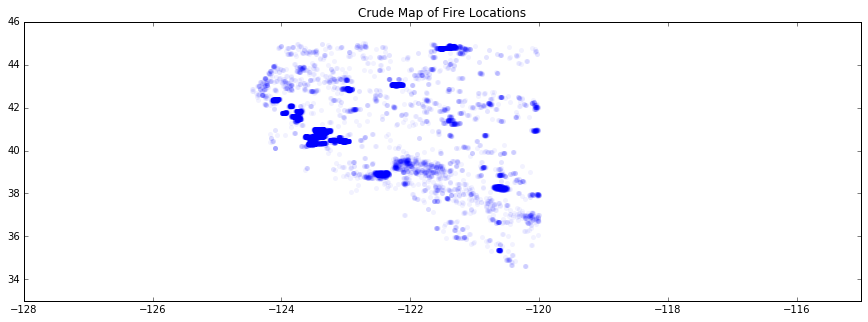

In [9]:
%%juno 

fig, ax = plt.subplots(1, figsize=(15,5))
plt.title('Crude Map of Fire Locations')
ax.set_ylim((33,46))
ax.set_xlim((-128,-115))
plt.scatter(lons, lats, s=25, marker='o', alpha=0.05, lw = 0)
plt.show()

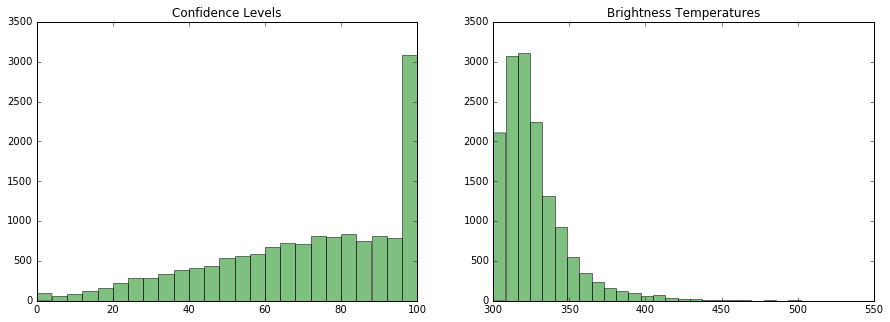

In [10]:
%%juno

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
ax1.set_title('Confidence Levels')
ax1.hist(confs, bins=25, alpha=.5, color='green')
ax2.set_title('Brightness Temperatures')
ax2.hist(temps, bins=25, alpha=.5, color='green')
plt.show()

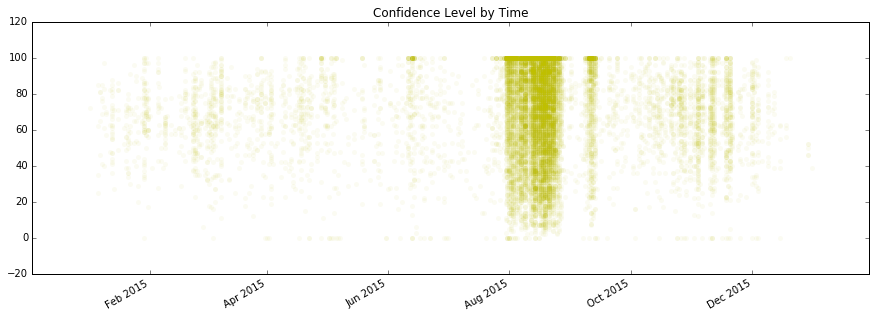

In [11]:
%%juno

fig, ax = plt.subplots(1, figsize=(15,5))
fig.autofmt_xdate()
ax.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')

plt.title('Confidence Level by Time')
plt.scatter(dates, confs, s=25, color='y', marker='o', alpha=0.05, lw = 0)
plt.show()

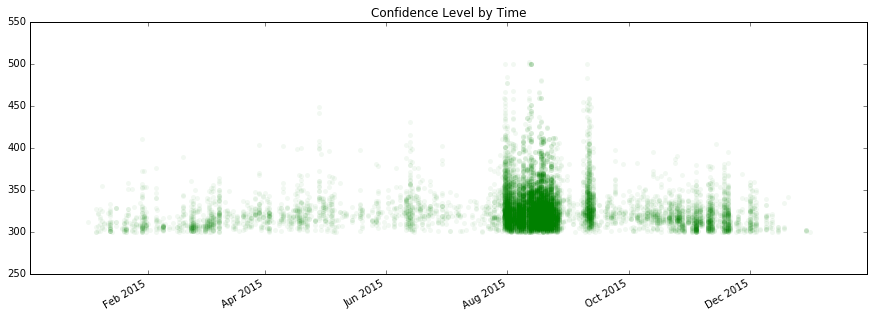

In [12]:
%%juno

fig, ax = plt.subplots(1, figsize=(15,5))
fig.autofmt_xdate()
ax.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')

plt.title('Confidence Level by Time')
plt.scatter(dates, temps, s=25, color='g', marker='o', alpha=0.05, lw = 0)
plt.show()

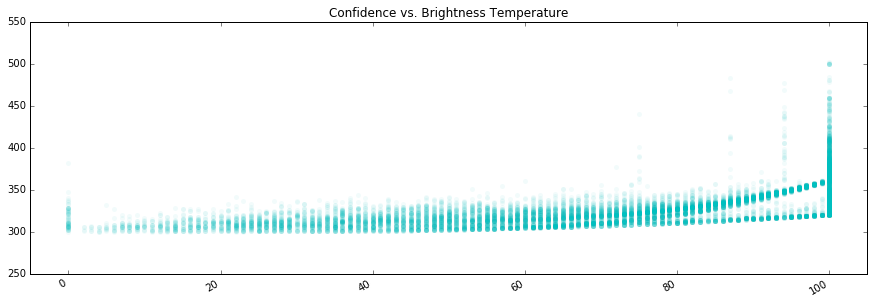

In [13]:
%%juno 

fig, ax = plt.subplots(1, figsize=(15,5))
fig.autofmt_xdate()
ax.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')
ax.set_xlim(-5, 105)
plt.title('Confidence vs. Brightness Temperature')
plt.scatter(confs, temps, s=25, color='c', marker='o', alpha=0.05, lw = 0)
plt.show()

In [15]:
%%juno

# Filters 
confidence_low = 90
temperature_low = 400


filtered = []
for f in fires['features']:
    props = f['properties']
    if props['CONF'] >= confidence_low and props['TEMP'] >= temperature_low:
        filtered.append(f)
        

display(HTML('<h2>%s Filtered Fire Events (Conf: %d, Temp: %d) </h2>' % (len(filtered), confidence_low, temperature_low)))

In [20]:
%%juno 

from dateutil.parser import parse
from datetime import datetime
from dateutil.relativedelta import relativedelta

# days before and after 
days = 20 
delta = relativedelta(days=days)

# list of all suitable areas for analysis 
suitable = []

# do the search results have images before AND after the event
def is_suitable(images, event, start, end):
    pre = []
    post = []
    for img in images:
        img_date = parse(img['properties']['date'])
        if img_date >= start and img_date < event:
            pre.append(img)
        elif img_date <= end and img_date > event:
            post.append(img)
     
    if len(pre) > 0 and len(post) > 0 and (pre[0]['properties']['path'] == post[0]['properties']['path']):
        pre, post = match(pre, post)
        return True, pre, post
    else:
        return False, None, None

def match_path_row(id1, id2):
    path_row1 = (id1[3:6], id1[6:9])
    path_row2 = (id2[3:6], id2[6:9])
    #print id1[3:6], 
    return path_row1 == path_row2

def match(pres, posts):
    new_pres, new_posts = [], []
    for pre in pres:
        pre_id = pre['properties']['sceneID']
        for post in posts:
            post_id = pre['properties']['sceneID']
            if match_path_row(pre_id, post_id):
                #print 'match', (pre_id[3:6], pre_id[6:9]) == (post_id[3:6], post_id[6:9])
                new_pres, new_posts = [pre], [post]
                break
    #print new_pres[0]['properties']['path'] == new_posts[0]['properties']['path'] 
    return new_pres, new_posts

# search for images for every feature 
for i, f in enumerate(filtered):
    lon, lat = f['geometry']['coordinates']
    date = parse(f['properties']['DATE'])
    start_date = (date - delta)
    end_date = (date + delta)
    
    try:
        hits = search_landsat(lon, lat, 
                      cloud_max=5, 
                      start_date=start_date.strftime('%Y-%m-%d'),
                      end_date=end_date.strftime('%Y-%m-%d'),
                      geojson=True,
                      limit=100
                     )
        if 'features' in hits and len(hits['features']) > 1:
            good, pre, post = is_suitable(hits['features'], date, start_date, end_date)
            if good is True:
                suitable.append({'pre': pre, 'post': post, 'feature': f})
    except:
        pass
    
display(HTML('<h2>%s Suitable Areas Found</h2>' % str(len(suitable))))

In [21]:
%%juno
import json

print "index", "conf", "temp", "date"
for i, a in enumerate(suitable):
    p = a['feature']['properties']
    print i, p['CONF'], p["TEMP"], p['DATE'], p['LAT'], p['LONG']

index conf temp date
0 100 400.2 2015/08/05 44.564 -121.186
1 100 410.8 2015/08/01 43.291 -123.001
2 100 410.2 2015/07/29 39.427 -121.388
3 100 406.2 2015/08/02 38.994 -122.465
4 100 405.9 2015/08/03 38.992 -122.51
5 100 402.6 2015/08/02 38.984 -122.457
6 100 413.4 2015/07/31 38.96 -122.493
7 100 400 2015/07/31 38.958 -122.506
8 100 445 2015/07/31 38.949 -122.503
9 100 401.3 2015/07/31 38.944 -122.474
10 100 411.2 2015/07/31 38.935 -122.526
11 100 415.5 2015/07/31 38.932 -122.54
12 100 500.6 2015/07/31 38.93 -122.553
13 100 441.9 2015/07/31 38.928 -122.566
14 100 458.5 2015/07/31 38.921 -122.55
15 100 413.8 2015/07/31 38.918 -122.543
16 100 401.1 2015/07/31 38.917 -122.419
17 100 424.4 2015/07/31 38.916 -122.557
18 100 450.3 2015/07/31 38.912 -122.401
19 100 434.8 2015/07/31 38.906 -122.414
20 100 439.4 2015/07/31 38.906 -122.408
21 100 410.7 2015/07/31 38.896 -122.412
22 100 425.7 2015/07/30 38.886 -122.49
23 100 459.7 2015/07/30 38.884 -122.512
24 100 422.2 2015/08/11 38.869 -122.505

In [22]:
%%juno

# Compares pre/post burn indices 
def compare_indices(sceneId1, sceneId2, geometry, buff=0.05, cache=False):
    pnt = shape(geometry)
    bbox = pnt.buffer(buff).bounds

    pre = create_index(sceneId1, 'NBR', bbox=bbox, use_cache=cache)
    post = create_index(sceneId2, 'NBR', bbox=bbox, use_cache=cache)
    pre_rgb = create_rgb(sceneId1, bbox=bbox, use_cache=cache)
    post_rgb = create_rgb(sceneId2, bbox=bbox, use_cache=cache)
    
    diff = rescale_intensity(pre - post, out_range=(0,1))
    
    return {'visual': [pre_rgb, post_rgb],
            'indices': [pre, post],
            'difference': diff}

def render_indices(result):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,10))
    ax1.set_title('Before')
    ax1.imshow(result['indices'][0], cmap='Spectral_r')
    ax1.axis('off')

    ax2.set_title('After')
    ax2.imshow(result['indices'][1], cmap='Spectral_r')
    ax2.axis('off')

    ax3.set_title('Difference')
    ax3.imshow(result['difference'], cmap='Spectral_r')
    ax3.axis('off')
    plt.show()
    
def render_visual(result):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,10))
    ax1.set_title('Before')
    ax1.imshow(result['visual'][0])
    ax1.axis('off')

    ax2.set_title('After')
    ax2.imshow(result['visual'][1])
    ax2.axis('off')
    plt.show()

In [31]:
%%juno

area = suitable[5]

pre_meta = area['pre'][0]['properties']
post_meta = area['post'][0]['properties']

result = compare_indices(pre_meta['sceneID'], post_meta['sceneID'], area['feature']['geometry'], buff=0.1, cache=False)

>> Reading band 3

>> Reading band 4

>> Reading band 5

>> Reading band 7

 Done.

>> Reading band 3

>> Reading band 4

>> Reading band 5

>> Reading band 7

 Done.
 Creating Color Corrected RGB for: LC80440332015208LGN00


>> Reading band 2

>> Reading band 2

>> Reading band 3

>> Reading band 4

>> Reading band 5

>> Reading band 7

>> Reading band 8

>> Reading band 8

 Done.


 Creating Color Corrected RGB for: LC80440332015224LGN00


>> Reading band 2

>> Reading band 2

>> Reading band 3

>> Reading band 4

>> Reading band 5

>> Reading band 7

>> Reading band 8

>> Reading band 8

 Done.

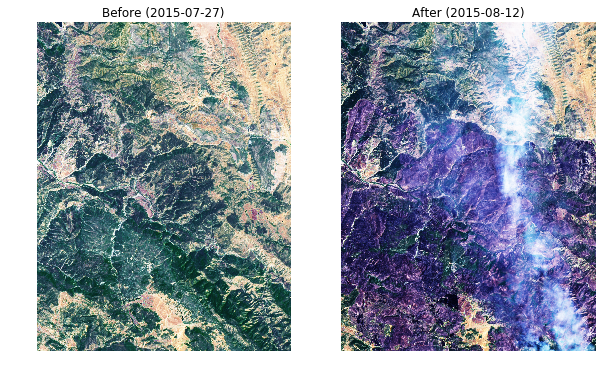

In [32]:
%%juno

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,10))
ax1.set_title('Before (%s)' % pre_meta['date'])
ax1.imshow(result['visual'][0])
ax1.axis('off')
ax2.set_title('After (%s)' % post_meta['date'])
ax2.imshow(result['visual'][1])
ax2.axis('off')
plt.show()

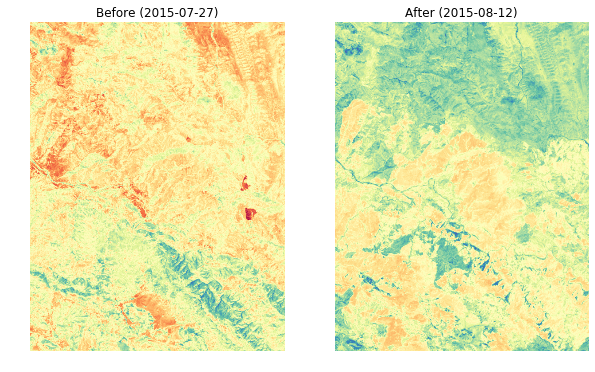

In [33]:
%%juno

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,10))
ax1.set_title('Before (%s)' % pre_meta['date'])
ax1.imshow(result['indices'][0], cmap='Spectral')
ax1.axis('off')
ax2.set_title('After (%s)' % post_meta['date'])
ax2.imshow(result['indices'][1], cmap='Spectral')
ax2.axis('off')
plt.show()

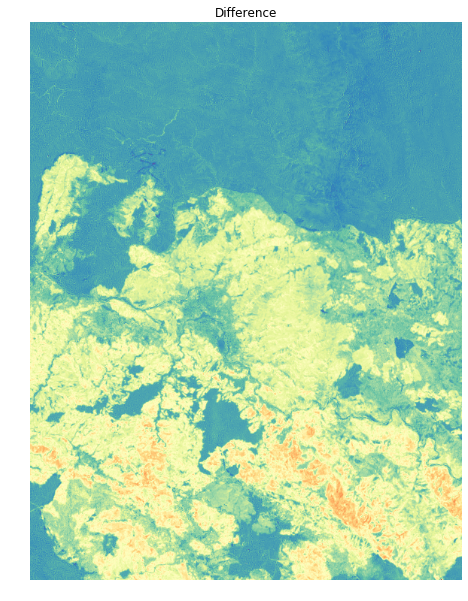

In [34]:
%%juno

fig, ax = plt.subplots(1, figsize=(10,10))
ax.set_title('Difference')
ax.imshow(result['difference'], cmap='Spectral_r')
ax.axis('off')
plt.show()

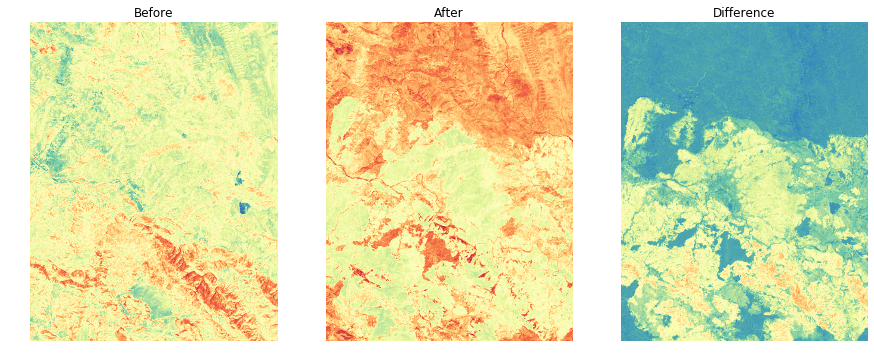

In [35]:
%%juno
render_indices(result)

>> Reading band 3

>> Reading band 4

>> Reading band 5

>> Reading band 7

 Done.

>> Reading band 3

>> Reading band 4

>> Reading band 5

>> Reading band 7

 Done.
 Creating Color Corrected RGB for: LC80430332015233LGN00


>> Reading band 2

>> Reading band 3

>> Reading band 4

>> Reading band 5

>> Reading band 7

>> Reading band 8

 Done.


 Creating Color Corrected RGB for: LC80430332015265LGN00


>> Reading band 2

>> Reading band 3

>> Reading band 4

>> Reading band 5

>> Reading band 7

>> Reading band 8

 Done.

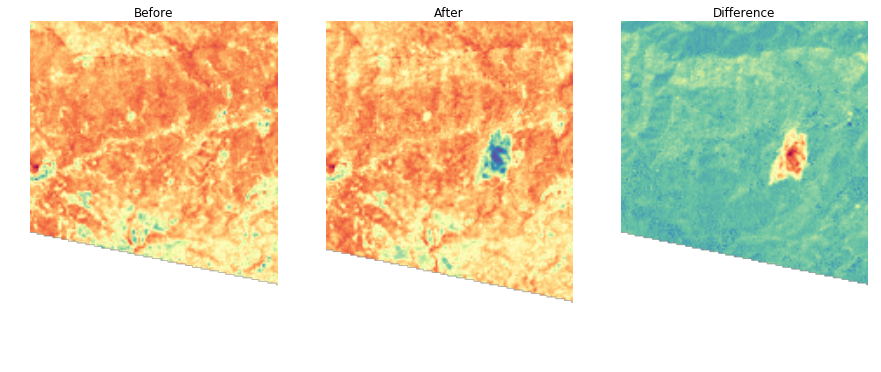

In [38]:
%%juno

area = suitable[-1]
pre_meta = area['pre'][0]['properties']
post_meta = area['post'][0]['properties']
result = compare_indices(pre_meta['sceneID'], post_meta['sceneID'], area['feature']['geometry'], buff=0.025, cache=False
render_indices(result)

>> Reading band 3

>> Reading band 4

>> Reading band 5

>> Reading band 7

 Done.

>> Reading band 3

>> Reading band 4

>> Reading band 5

>> Reading band 7

 Done.
 Creating Color Corrected RGB for: LC80440332015192LGN00


>> Reading band 2

>> Reading band 3

>> Reading band 4

>> Reading band 5

>> Reading band 7

>> Reading band 8

 Done.


 Creating Color Corrected RGB for: LC80440332015224LGN00


>> Reading band 2

>> Reading band 3

>> Reading band 4

>> Reading band 5

>> Reading band 7

>> Reading band 8

 Done.

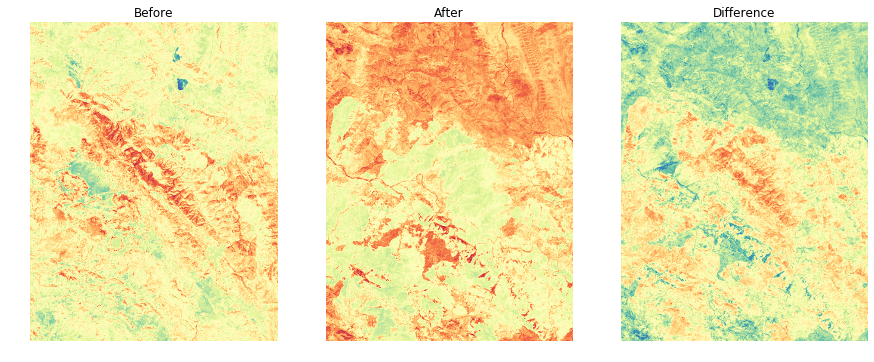

In [40]:
%%juno

area = suitable[20]
pre_meta = area['pre'][0]['properties']
post_meta = area['post'][0]['properties']
result = compare_indices(pre_meta['sceneID'], post_meta['sceneID'], area['feature']['geometry'], buff=0.1, cache=False)
render_indices(result)

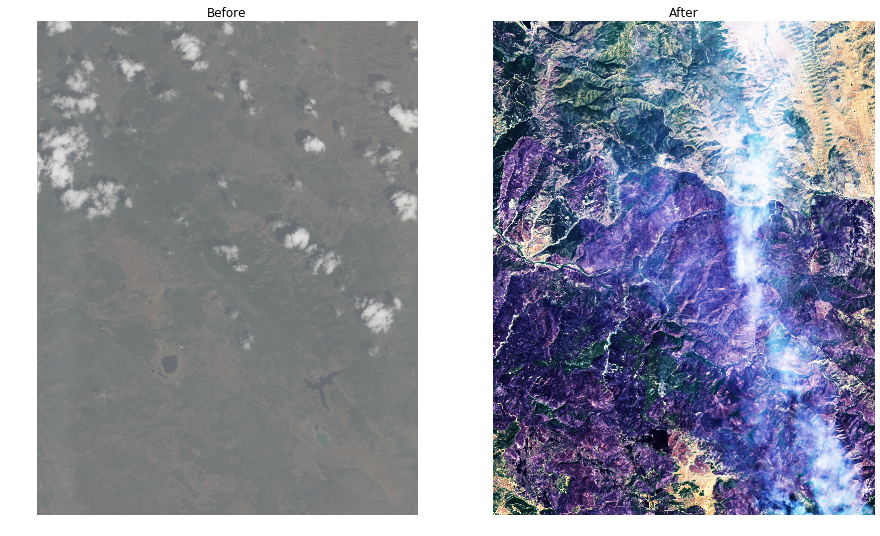

In [41]:
%%juno
render_visual(result)

>> Reading band 3

>> Reading band 3

>> Reading band 4

>> Reading band 4

>> Reading band 5

>> Reading band 5

>> Reading band 7

>> Reading band 7

 Done.

>> Reading band 3

>> Reading band 3

>> Reading band 4

>> Reading band 4

>> Reading band 5

>> Reading band 5

>> Reading band 7

>> Reading band 7

 Done.
 Creating Color Corrected RGB for: LC80430342015249LGN00


>> Reading band 2

>> Reading band 2

>> Reading band 3

>> Reading band 4

>> Reading band 5

>> Reading band 7

>> Reading band 8

>> Reading band 8

 Done.


 Creating Color Corrected RGB for: LC80430332015265LGN00


>> Reading band 2

>> Reading band 2

>> Reading band 3

>> Reading band 4

>> Reading band 5

>> Reading band 7

>> Reading band 8

>> Reading band 8

 Done.

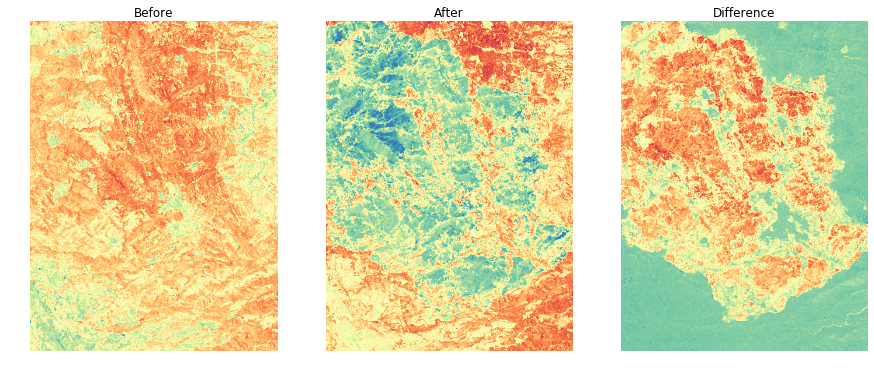

In [42]:
%%juno

area = suitable[50]
pre_meta = area['pre'][0]['properties']
post_meta = area['post'][0]['properties']
result = compare_indices(pre_meta['sceneID'], post_meta['sceneID'], area['feature']['geometry'], buff=0.1, cache=False)
render_indices(result)


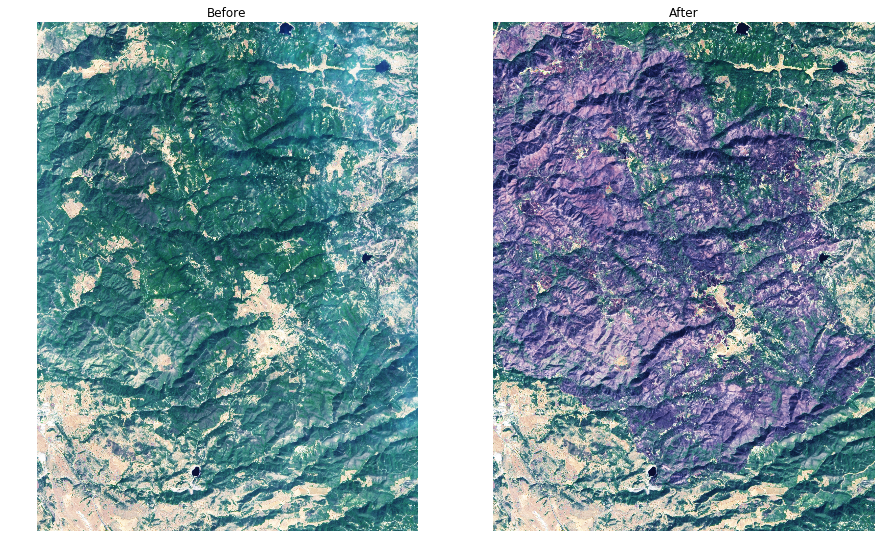

In [43]:
%%juno

render_visual(result)